# Building a LogS Regression Model

We will build a regression model for the Biogen solubility dataset: https://pubs.acs.org/doi/10.1021/acs.jcim.3c00160

### Step 1: Import all necessary libraries that might be necessary

In [6]:
from rdkit import Chem
from rdkit.Chem import AllChem, rdmolops, Draw, Descriptors, rdDepictor, PandasTools, rdMolDescriptors as rdmd;
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import rdkit
print(f"I am RDKit version: {rdkit.__version__}")
import sys
print(f"I am python version {sys.version}")

I am RDKit version: 2023.09.5
I am python version 3.10.0 (default, Feb 27 2024, 12:29:18) [Clang 15.0.0 (clang-1500.1.0.2.5)]


### Step 2: Check out what the dataframe looks like

In [7]:
df = pd.read_csv("../data/biogen_solubility.csv")
print(f"The dataset contains {df.shape[0]} endpoints on LogS")
df.head(3)

The dataset contains 2173 endpoints on LogS


,Internal ID,Vendor ID,SMILES,logS
0,Mol1,317714313,CNc1cc(Nc2cccn(-c3ccccn3)c2=O)nn2c(C(=O)N[C@@H...,-5.548020
1,Mol2,324056965,CCOc1cc2nn(CCC(C)(C)O)cc2cc1NC(=O)c1cccc(C(F)F)n1,-5.071409
2,Mol4,194963090,CC(C)(Oc1ccc(-c2cnc(N)c(-c3ccc(Cl)cc3)c2)cc1)C...,-3.925969


<Axes: xlabel='logS', ylabel='Count'>

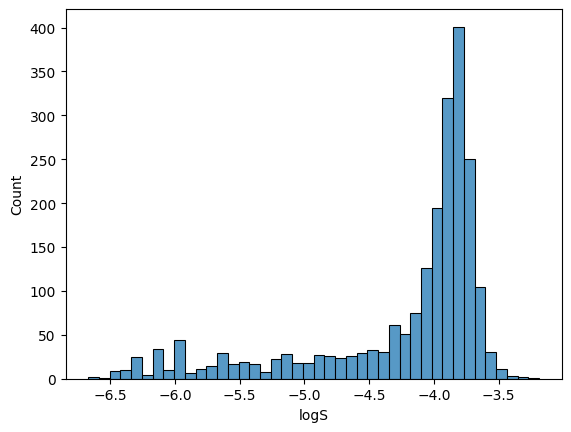

In [8]:
# Let's check the distribution of values:

sns.histplot(df.logS)

### Step 3: We now sanitize the dataset: check for faulty smiles and remove smiles with impurities

In [9]:
import sys
sys.path.insert(0, '/Users/ganeshshahane/Work/useful_cheminformatics/')

In [10]:
# remove smiles with invalid syntax:
from utils_pack import remove_faulty_smiles, clean_sanitize_dataframe

df = remove_faulty_smiles.remove(df, 'SMILES')

There are 0 invalid smiles in the dataset


Salts can have a huge influence on aqueous solubility, and hence it's not appropriate to include them in the training set. Let's remove salts and hydrates by removing any molecule containing more than one fragment:

In [11]:
# remove smiles with mutiple fragments and transition metals

new_df = clean_sanitize_dataframe.filter_smiles(df, 'SMILES')
print(f"{df.shape[0] - new_df.shape[0]} molecules have been removed by because of transition metals or salts")

3 molecules have been removed by because of transition metals or salts


In [12]:
# Check which SMILES have been removed:

differences = pd.concat([df, new_df]).drop_duplicates(subset='SMILES', keep=False)

differences.SMILES.to_list()

['COc1ccc(-c2nc(CC(N)=O)sc2C)cc1.Cl',
 'CCN1CCN(Cc2ccc(Nc3ncc(F)c(-c4cc(F)c5nc(C)n(C(C)C)c5c4)n3)nc2)CC1.CS(=O)(=O)O',
 'CN(CCOCCOc1ccccc1-c1ccccc1)Cc1ccccc1.O=C(O)C(=O)O']

As one can see, these entries are salts or contain multiple fragments

#### Finally, visualise the molecules:

In [13]:
# Calculate the mol object:
new_df['mol'] = new_df['SMILES'].apply(Chem.MolFromSmiles)

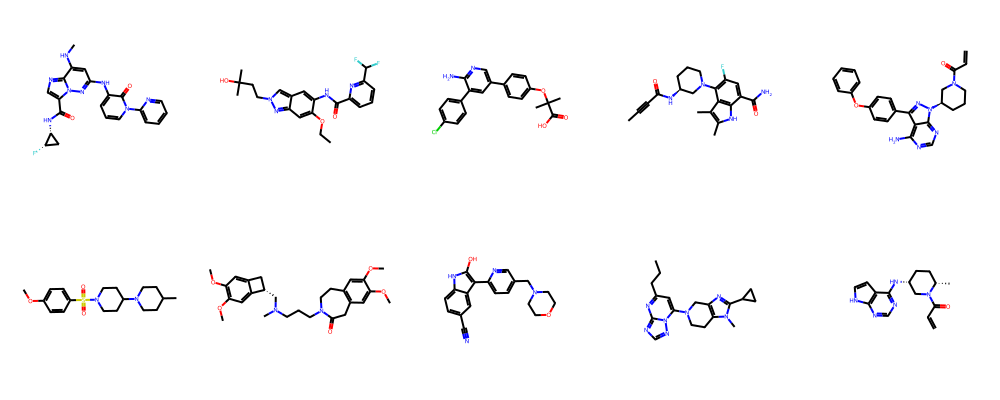

In [14]:
# Visualise some of the molecules:
Draw.MolsToGridImage(new_df.mol[:10], molsPerRow=5)

In [15]:
new_df.head(5)

,Internal ID,Vendor ID,SMILES,logS,mol
0,Mol1,317714313,CNc1cc(Nc2cccn(-c3ccccn3)c2=O)nn2c(C(=O)N[C@@H...,-5.548020,<rdkit.Chem.rdchem.Mol object at 0x2b408eab0>
1,Mol2,324056965,CCOc1cc2nn(CCC(C)(C)O)cc2cc1NC(=O)c1cccc(C(F)F)n1,-5.071409,<rdkit.Chem.rdchem.Mol object at 0x2b408eb20>
2,Mol4,194963090,CC(C)(Oc1ccc(-c2cnc(N)c(-c3ccc(Cl)cc3)c2)cc1)C...,-3.925969,<rdkit.Chem.rdchem.Mol object at 0x2b408eb90>
3,Mol6,316230505,CC#CC(=O)N[C@H]1CCCN(c2c(F)cc(C(N)=O)c3[nH]c(C...,-4.535280,<rdkit.Chem.rdchem.Mol object at 0x2b408ec00>
4,Mol9,EN300-97039,C=CC(=O)N1CCC[C@@H](n2nc(-c3ccc(Oc4ccccc4)cc3)...,-4.709963,<rdkit.Chem.rdchem.Mol object at 0x2b408ec70>


### Step 4: Generate features

In [16]:
# We use the molfeat package to generate descriptors

from molfeat.calc import FPCalculator
from molfeat.trans import MoleculeTransformer

In [17]:
# Instantiate a Fingerprint calculator
calc = FPCalculator("ecfp")

# Instantiate a molecule transfomer from molfeat. This object takes a list of SMILES as input and returns descriptors.
trans = MoleculeTransformer(calc)

In [18]:
import datamol as dm

with dm.without_rdkit_log():
    
    new_df['fp'] = trans.transform(new_df.SMILES.values)

In [19]:
new_df.head(2)

,Internal ID,Vendor ID,SMILES,logS,mol,fp
0,Mol1,317714313,CNc1cc(Nc2cccn(-c3ccccn3)c2=O)nn2c(C(=O)N[C@@H...,-5.548020,<rdkit.Chem.rdchem.Mol object at 0x2b408eab0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,Mol2,324056965,CCOc1cc2nn(CCC(C)(C)O)cc2cc1NC(=O)c1cccc(C(F)F)n1,-5.071409,<rdkit.Chem.rdchem.Mol object at 0x2b408eb20>,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


### Step 5: Train-Test split

In [20]:
# Split the data into training and test sets

from sklearn.model_selection import train_test_split

X = pd.DataFrame(new_df['fp'].tolist()) # put features in a dataframe called X
y = new_df.logS # put features in series y

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9, random_state=0)

The features, in this case the fingerprints, are labelled as 'X'. Thus, the features to be used for training and testing go into X_train and X_test respectively

The target to predict goes into 'y'. Hence, the target values to be used in training goes into y_train and those for testing go into y_test.

In [21]:
from sklearn.ensemble import HistGradientBoostingRegressor

# Initiate the regressor:
est = HistGradientBoostingRegressor()

# Fit the training data:
est.fit(X_train, y_train)

HistGradientBoostingRegressor()

### Step 6: Predict logS on molecules in the testing set:

In [22]:
X_test_predictions = est.predict(X_test)

X_test_predictions[:10]

array([-3.92734226, -3.87515296, -4.81099112, -4.744818  , -4.06342783,
       -4.12508073, -4.8436476 , -3.99417097, -3.50554175, -5.69888708])

In [23]:
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_test, X_test_predictions)
r2 = r2_score(y_test, X_test_predictions)

print(f"MSE: {mse}")
print(f"R2 score: {r2}")

MSE: 0.30016237889427333
R2 score: 0.2945833749145852


This is at best a poor positive correlation. The model isn't very good.

Let's visualise the regression:

<Axes: xlabel='logS'>

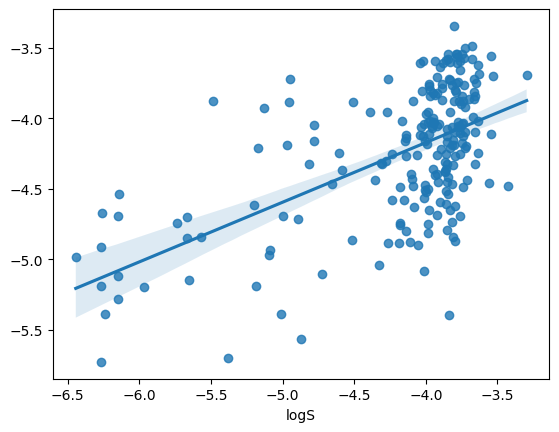

In [24]:
sns.regplot(x=y_test, y=X_test_predictions)

We can see the large blob of data with experimental logS (on X-axis) between -4.7 and -3.5 is predicted to be anywhere between -5.2 to -3.6.

I think we can do better.

### Step 7: Save & Reuse the model

In [25]:
import joblib

joblib.dump(est, '../saved_models/logS_regressor.model')

['../saved_models/logS_regressor.model']

#### Some time later...

In [26]:
# Load the saved model:

load_model = joblib.load('../saved_models/logS_regressor.model')

In order to predict the logS of a new molecule, you have to pass its features (in this case fingerprints) to the loaded model using predict(), and then convert those features in a series or dataframe:

In [27]:
load_model.predict(pd.DataFrame(trans.transform('CN1CCC23C4C1CC5=C2C(=C(C=C5)O)OC3C(C=C4)O')))

array([-3.98249578])

In [28]:
# For multiple molecules:

mol_list = ['CN1CCC23C4C1CC5=C2C(=C(C=C5)O)OC3C(C=C4)O', 'CCCC']

load_model.predict(pd.DataFrame(trans.transform(mol_list)))

array([-3.98249578, -3.72539141])

## However, can we improve the model's performance?

Let's try using 2D descriptors as features

In [29]:
from molfeat.calc import _CALCULATORS

print("The following descriptors are available in molfeat:")
_CALCULATORS.keys()

The following descriptors are available in molfeat:


dict_keys(['CATS', 'RDKitDescriptors2D', 'RDKitDescriptors3D', 'MordredDescriptors', 'FPCalculator', 'Pharmacophore2D', 'Pharmacophore3D', 'USRDescriptors', 'ElectroShapeDescriptors', 'ScaffoldKeyCalculator', 'AtomCalculator', 'AtomMaterialCalculator', 'DGLCanonicalAtomCalculator', 'DGLWeaveAtomCalculator', 'BondCalculator', 'EdgeMatCalculator', 'DGLCanonicalBondCalculator', 'DGLWeaveEdgeCalculator'])

In [35]:
# Instantiate a descriptor calculator
from molfeat.trans import MoleculeTransformer
from molfeat.calc import RDKitDescriptors2D

desc = RDKitDescriptors2D(replace_nan = True)

# Instantiate a molecule transfomer. This object takes a list of SMILES as input and returns descriptors.
featurizer = MoleculeTransformer(desc, dtype=np.float32)

with dm.without_rdkit_log():
    feats = featurizer(new_df.SMILES.values)

In [47]:
# A total of 216 2D descriptors are computed:
pd.DataFrame(feats).head(3)

,0,1,2,3,4,5,6,7,8,9,...,206,207,208,209,210,211,212,213,214,215
0,13.200851,13.200851,0.165008,-1.018011,0.424174,17.187500,434.434998,415.282990,434.161499,162.0,...,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0
1,12.876019,12.876019,0.114613,-2.761275,0.572869,11.833333,418.444000,394.252014,418.181641,160.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,11.185594,11.185594,0.434476,-1.299581,0.655493,11.222222,382.846985,363.695007,382.108429,138.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Next we normalise the features between 0 and 1

In [45]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Initialize
scaler = MinMaxScaler()

# Fit and transform the data
X_normalized = scaler.fit_transform(feats)

# Print the first few rows of the normalized data
print("Normalized Data (MinMaxScaler):")
pd.DataFrame(X_normalized).head(3)

Normalized Data (MinMaxScaler):


,0,1,2,3,4,5,6,7,8,9,...,206,207,208,209,210,211,212,213,214,215
0,0.785401,0.785401,0.149147,0.694327,0.333463,0.216066,0.551346,0.565188,0.551366,0.534653,...,0.0,0.0,0.0,0.0,0.285714,0.0,0.0,0.2,0.0,0.0
1,0.761285,0.761285,0.103591,0.443475,0.522669,0.073684,0.520333,0.521678,0.520353,0.524752,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.2,0.0,0.0
2,0.635787,0.635787,0.392746,0.653810,0.627802,0.057433,0.451297,0.458461,0.450343,0.415842,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


### Test-Train Splitting and model building

In [49]:
X = X_normalized # put features in a dataframe called X
y = new_df.logS # put features in series y

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9, random_state=0)

# Initiate the regressor:
gbm = HistGradientBoostingRegressor()

# Fit the training data:
gbm.fit(X_train, y_train)

# Predict logS of the testing set:
y_pred = gbm.predict(X_test)

# Show top 10 predictions
y_pred[:10]

array([-4.52256009, -3.81670542, -3.69156328, -5.02003141, -3.96106393,
       -3.99969419, -5.06108317, -3.8966118 , -3.75184204, -5.19536008])

In [50]:
# Evaluate the model's predictions:

mse_gbm = mean_squared_error(y_test, y_pred)
r2_gbm = r2_score(y_test, y_pred)

print(f"MSE: {mse_gbm}")
print(f"R2 score: {r2_gbm}")

MSE: 0.21347353065704147
R2 score: 0.49831228651675963


One can see that the MSE and R2 score are much improved: MSE has decreased by one-third and the correlation has increased from 0.3 to 0.49.

Now let's visualise the correlation:

<Axes: xlabel='logS'>

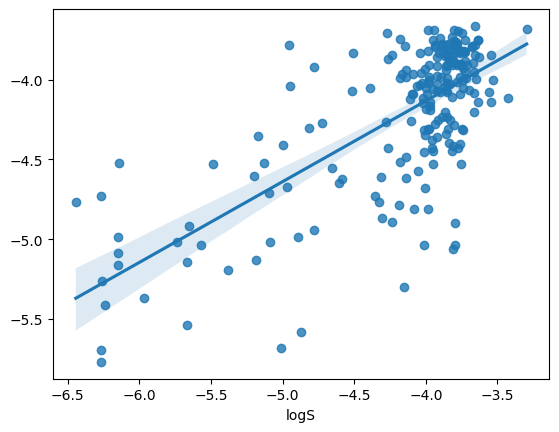

In [51]:
sns.regplot(x=y_test, y=y_pred)

In [52]:
# Let's save the model:

joblib.dump(gbm, '../saved_models/logS_regressor_V2.model')

['../saved_models/logS_regressor_V2.model']

In [54]:
# Sometime later:

model_V2 = joblib.load('../saved_models/logS_regressor_V2.model')

When testing the model on new molecules, the model automatically normalizes its generated features:

In [84]:
# Predicting value of one molecule:

model_V2.predict(pd.DataFrame(featurizer('CN1CCC23C4C1CC5=C2C(=C(C=C5)O)OC3C(C=C4)O')))

[11:32:57] Initializing MetalDisconnector
[11:32:57] Running MetalDisconnector
[11:32:57] Initializing Normalizer
[11:32:57] Running Normalizer
[11:32:57] Initializing MetalDisconnector
[11:32:57] Running MetalDisconnector
[11:32:57] Initializing Normalizer
[11:32:57] Running Normalizer


-4.545354389901828

In [64]:
# For multiple molecules:

mol_list = ['CN1CCC23C4C1CC5=C2C(=C(C=C5)O)OC3C(C=C4)O', 'CCCC']

model_V2.predict(pd.DataFrame(featurizer(mol_list)));

[11:20:53] Initializing MetalDisconnector
[11:20:53] Running MetalDisconnector
[11:20:53] Initializing Normalizer
[11:20:53] Running Normalizer
[11:20:53] Initializing MetalDisconnector
[11:20:53] Running MetalDisconnector
[11:20:53] Initializing Normalizer
[11:20:53] Running Normalizer
[11:20:53] Initializing MetalDisconnector
[11:20:53] Running MetalDisconnector
[11:20:53] Initializing Normalizer
[11:20:53] Running Normalizer
[11:20:53] Initializing MetalDisconnector
[11:20:53] Running MetalDisconnector
[11:20:53] Initializing Normalizer
[11:20:53] Running Normalizer


In [98]:
# Predicting values for molecules in a dataframe:

sample_df = pd.DataFrame({           # define a sample dataframe
    'ID':[1, 2],
    'smiles': ['c1ccccc1N', 'CCON']
    })

sample_df

,ID,smiles
0,1,c1ccccc1N
1,2,CCON


In [103]:
# Define a function to return the predicted logS:

def predict_logS(smiles):
    
    return model_V2.predict(pd.DataFrame(featurizer(smiles))).item()

In [104]:
sample_df['predicted_logS'] = sample_df['smiles'].apply(predict_logS)

[11:38:43] Initializing MetalDisconnector
[11:38:43] Running MetalDisconnector
[11:38:43] Initializing Normalizer
[11:38:43] Running Normalizer
[11:38:43] Initializing MetalDisconnector
[11:38:43] Running MetalDisconnector
[11:38:43] Initializing Normalizer
[11:38:43] Running Normalizer
[11:38:43] Initializing MetalDisconnector
[11:38:43] Running MetalDisconnector
[11:38:43] Initializing Normalizer
[11:38:43] Running Normalizer
[11:38:43] Initializing MetalDisconnector
[11:38:43] Running MetalDisconnector
[11:38:43] Initializing Normalizer
[11:38:43] Running Normalizer


In [105]:
sample_df

,ID,smiles,predicted_logS
0,1,c1ccccc1N,-5.255456
1,2,CCON,-4.686638
